## Data analytics assignment w/ Pandas and Socrata API

As per the assignment's instructions, we will demonstrate a technique/process from our course and apply it to some publicly available data set. While not a requirement for the assignment, we will also use this opportunity to utilize an API to retrieve the data which we will then filter and format into a useable form. _We definitely aren't doing this extra work so I can have a reference document for the future that covers SODA API and dataframes. No way, that would be silly._ 


### Background
One of the finer points of frustration of living in a quiet Seattle neighborhood is the constant worry that my neighbors are judging me. There have been a few occasions in the past of a neighbor making complaints about unkempt houses in my neighborhood, including my own property. I'd say that as we come out of winter the only real motivation I have to start mowing and keeping vegetation trim is brought on by the fear that somebody will complain. Am I alone in that worry? Do people really complain about vegetation less in winter when things don't grow? Let's find out!


### Getting our data
The city of Seattle releases and maintains a plethora of databases, one of which we are going to access. In order to do so, we'll need to use the SODA API.

To use the SODA API we import the Socrata module. The imported configs holds our app token so that it won't be publicly available when uploaded to github. You can learn how to generate your own app token [here](https://support.socrata.com/hc/en-us/articles/360015776014-API-Keys), for free.


In [1]:
import configs as cfg
from sodapy import Socrata

To access our data, we need identifiers for our endpoint. Our domain is data.seattle.gov and the specific dataset we are pulling from, [Code Complaints and Violations](https://data.seattle.gov/Community/Code-Complaints-and-Violations/ez4a-iug7) is identified by ez4a-iug7.

Using our token we build our client to query

In [2]:

data_url ="data.seattle.gov"
data_set="ez4a-iug7"

app_token = cfg.atoken
client=Socrata(data_url,app_token)


Unfortunately, the dataset we are looking at is quite big and we can only query for 50,000 rows or less per go. First, we'll check for the size of our dataset and from there we will download in pieces using offset.

In [3]:
count = client.get(data_set, select="COUNT(*)")
print(count)

[{'COUNT': '172181'}]


With over 170,000 records we need to request multiple times, which we can do via offsets to increment through the database.

In [4]:
import pandas as pd

start = 0
block = 5000
results = []
while start < int(count[0]['COUNT']):
    results.extend(client.get(data_set, offset=start, limit=block))
    start +=block
    
df = pd.DataFrame.from_records(results)

df.to_csv("complaintsdata.csv")


## The dataset

The dataset we've just pulled is a database of complaints filed to the Seattle Department of Construction & Inspections. The database contains all complaints filed by phone, online, and via the more recent "Find it, Fix it" app. Complaints can be varied from street vendors using land improperly to elevators not working in buildings or potholes needing to be fixed. The data isn't curated into precise categories, as the categories may be user selected and thus not the most trustworthy, but that is dependent on the vagueness of reports. 

Besides inaccuracy due to the variety of user input, there are a few more caveats to using the database

* The dataset holds records from as far back as 2003, but the "Find it, Fix it" app wasn't released until 2013, which can skew any statistical outcomes if we look at data over time. Unfortunately we don't have any user statistics or complaint demographics so there doesn't seem to be any nice way to normalize
* The category of complaint isn't required to be set when making your submission, meaning if we try to find records pertaining to vegetation, we need to filter beyond the record type and examine the content of some complaints
* The dataset is indexed on each complaint, as opposed to complaints per day, so we need to count the dataset if we want to analyze by individual dates.


### Goal


We have a massive dataset with lots of stuff we don't care about. For the purposes of this project, we want to transform the dataset into the following:

* only reports that occur in a single calendar year, Jan 1 2020 to Dec 31 2020
* we want reports concerning vegetation, which we'll extend to those containing the keywords 'weeds', 'vegetation', 'moss', 'overgrown', 'overgrowth', and 'vines'
* per day complaint counts for each day to look at trends


Once we have a data set with complaint counts for each day we can begin our statistical analysis. 

Moving forward, we have just downloaded a massive amount of data, to the tune of an ~87 mb .CSV file. So, lets focus on filtering some of that info down, starting with their dates.

In [5]:
df=pd.read_csv("complaintsdata.csv")

print(df.columns.tolist())

['Unnamed: 0', 'recordnum', 'recordtype', 'recordtypemapped', 'recordtypedesc', 'description', 'opendate', 'inspectiondate', 'lastinspresult', 'statuscurrent', 'originaladdress1', 'originalcity', 'originalstate', 'originalzip', 'link', 'latitude', 'longitude', 'location1']


We see two different fields relating to date, 'opendate' and 'inspectiondate'. For the purposes of targeting the people who are making the complaints and not the organization's response, we'll use the prior.  

In [6]:
y20 = df[(df['opendate'] >= '2020-01-01') & (df['opendate'] < '2021-01-01')]
y20.shape

(12419, 18)

We've already made a big reduction in entries, from 172149 to 12419! From here, lets examine the columns to reduce further.

In [7]:
y20.head()

,Unnamed: 0,recordnum,recordtype,recordtypemapped,recordtypedesc,description,opendate,inspectiondate,lastinspresult,statuscurrent,originaladdress1,originalcity,originalstate,originalzip,link,latitude,longitude,location1
141530,141530,1049066-VI,Notice of Violation,Case,NaN,Per Online; The owner of this house did not ob...,2020-09-16,"{'type': 'Point', 'coordinates': [-122.2997167...",Compliance Achieved,Completed,176 25TH AVE,SEATTLE,WA,98122.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.603513,-122.299717,"{'latitude': '47.60351336', 'longitude': '-122..."
142748,142748,000101-20CP,Complaint,Request,Land Use,Continue to allow trash to build up on deck an...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.2906583...",Completed,Completed,1403 33RD AVE,SEATTLE,WA,98122.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.613063,-122.290658,"{'latitude': '47.61306347', 'longitude': '-122..."
142749,142749,000102-20CP,Complaint,Request,NaN,I need to turn the heat up to 80 to warm the a...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3231740...",NaN,Completed,520 TERRY AVE,SEATTLE,WA,98104.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.606010,-122.323174,"{'latitude': '47.60601001', 'longitude': '-122..."
142750,142750,000103-20CP,Complaint,Request,Construction,Houses under construction have a Porta Potty p...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3112108...",NaN,Completed,1605 E MARION ST,SEATTLE,WA,98122.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.610543,-122.311211,"{'latitude': '47.6105427', 'longitude': '-122...."
142751,142751,000104-20CP,Complaint,Request,NaN,I live in a rental in the basement of this hom...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3337614...",NaN,Closed,11328 Meridian AVE N,NaN,NaN,NaN,{'url': 'https://cosaccela.seattle.gov/portal/...,47.711339,-122.333761,"{'latitude': '47.71133856', 'longitude': '-122..."


We see that 'recordtype' allows for multiple types of entries outside of complaints, which we wouldn't care about.

In [8]:
y20Complaint = y20[y20['recordtype'] =='Complaint']

Now, we begin filtering by our subject matter. We have two ways we will now reduce our dataset. 

* include all entries with 'recordtypedesc' == 'weeds'
* include all entries with the keywords 'weeds', 'vegetation', 'moss', 'overgrown', 'overgrowth', or 'vines' in 'description'

To do that, we'll make a mask for each bullet, combine them, and apply them to our dataframe.

In [18]:
keywords = ['weeds', 'vegetation', 'moss', 'overgrown', 'overgrowth', 'vines']
regstring = '|'.join(keywords)
keymask = y20Complaint['description'].str.contains(regstring, case = False, na=False) #remove case sensitivity and set all empty cells to false
print(keymask.value_counts()) #find how many have our keywords
typedescmask = y20Complaint['recordtypedesc']=='Weeds'
print(typedescmask.value_counts()) #find how many have the 'Weeds' as their 'typedescmask'
fy20 = y20Complaint[keymask | typedescmask] #selects only rows if either mask has a True
print(fy20.shape)
fy20.to_csv("vegcomplaints.csv")
fy20.head()

False    9431
True     1200
Name: description, dtype: int64
False    8986
True     1645
Name: recordtypedesc, dtype: int64
(1850, 18)


,Unnamed: 0,recordnum,recordtype,recordtypemapped,recordtypedesc,description,opendate,inspectiondate,lastinspresult,statuscurrent,originaladdress1,originalcity,originalstate,originalzip,link,latitude,longitude,location1
142753,142753,000106-20CP,Complaint,Request,Vacant Building,Per Online; Building is vacant. The front door...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.2779773...",Completed,Completed,7856 RENTON AVE S,SEATTLE,WA,98118.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.531858,-122.277977,"{'latitude': '47.53185787', 'longitude': '-122..."
142777,142777,000125-20CP,Complaint,Request,Weeds,Pines trees overhanging low over sidewalk and ...,2020-01-02,"{'type': 'Point', 'coordinates': [-122.4116831...",Completed,Completed,2802 43RD AVE W,SEATTLE,WA,98199.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.645180,-122.411683,"{'latitude': '47.64518008', 'longitude': '-122..."
142834,142834,000167-20CP,Complaint,Request,Land Use,Per Online; This vacant lot has rubbish and ga...,2020-01-03,"{'type': 'Point', 'coordinates': [-122.3600084...",NaN,Completed,10547 2nd AVE NW,NaN,NaN,NaN,{'url': 'https://cosaccela.seattle.gov/portal/...,47.706473,-122.360008,"{'latitude': '47.70647282', 'longitude': '-122..."
142853,142853,000185-20CP,Complaint,Request,"Emergency , Vacant Building",Open to entry outdoor storage overgrown vegeta...,2020-01-06,"{'type': 'Point', 'coordinates': [-122.3463936...",Completed,Completed,8842 9TH AVE SW,SEATTLE,WA,98106.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.523409,-122.346394,"{'latitude': '47.52340934', 'longitude': '-122..."
142900,142900,000225-20CP,Complaint,Request,Weeds,Lavender bushes are still covering 2/3 of the ...,2020-01-06,"{'type': 'Point', 'coordinates': [-122.3686227...",NaN,Completed,2602 9th AVE W,NaN,NaN,NaN,{'url': 'https://cosaccela.seattle.gov/portal/...,47.643287,-122.368623,"{'latitude': '47.64328713', 'longitude': '-122..."


We can now see we've further reduced our dataset from 12419 entries to 1850! Also, from the first few entries, we can see that while we have the entries marked 'Weeds' we are also including complaints about overgrowth from other categories also.

Finally, after a less than easy time redicing information, we have all the information we want. Now we can start counting them by day and inserting those counts into a new dataframe.

In [10]:
import numpy as np #for arange

fy20 = pd.read_csv("vegcomplaints.csv")

dates = pd.date_range(start='2020-01-01', end='2020-12-31').strftime('%Y-%m-%d') #builds an index for each day in the year
days = np.arange(0,366)
vegCounts = pd.DataFrame(data = dates,columns = ['dates']) #initialize dataframe with dates
counts = []
for x in days:
    counts.append(len(fy20[fy20["opendate"] == vegCounts.iloc[x,0]]))
vegCounts['counts'] = counts
vegCounts.head(10)



,dates,counts
0,2020-01-01,1
1,2020-01-02,2
2,2020-01-03,3
3,2020-01-04,0
4,2020-01-05,0
5,2020-01-06,4
6,2020-01-07,2
7,2020-01-08,4
8,2020-01-09,10
9,2020-01-10,3


We have our daily counts!
Now, we want to separate two portions of our database for statistical analysis: winter and summer, separated along the solstices/equinoxes. 
We want:
* average and std for winter (time from 1/1 to start of spring 3/19 and then start of winter 12/21 to 12/31)
* avg and std for summer (time from start of summer 6/20 to start of fall 9/22)

In [11]:
winterC = vegCounts[
    ((vegCounts['dates'] >= "2020-01-01") & (vegCounts['dates'] < "2020-03-19"))
    |
    ((vegCounts['dates'] >= "2020-12-21") & (vegCounts['dates'] < "2020-12-31"))]

summerC = vegCounts[
    (vegCounts['dates'] >= "2020-06-20") & (vegCounts['dates'] < "2020-09-22")]
wN = len(winterC) #size
sN = len(summerC)
wAvg = winterC["counts"].mean()
wSTD = winterC["counts"].std()
sAvg = summerC["counts"].mean()
sSTD = summerC["counts"].std()
print(wAvg, wSTD, sAvg, sSTD)

3.4545454545454546 3.0958225130638377 7.340425531914893 5.167210914427612


### Statistics

** The following is an application of procedure 5.7.3, the unpaired $t$-test for the difference between two population means.

We hypothesize that, in general, people are more likely to file complaints for vegetation-based issues in winter than during the summer. We have two samples, one being the amount of complaints in winter 2020 and the other in summer 2020. we are not analyzing information outside of 2020, only the subset of 2020. So, we will approach the problem as a two-sample unpaired t-test, with a significance level of 0.05. Unpaired because while they are both subsets of 2020, we are testing for summer and winter in general which are distinct periods.

So, we form the following null and alternate hypotheses:
$$
H_{0}: \mu _{w} = \mu _{s} \\ 
H_{a}: \mu _{w} < \mu _{s}
$$

And find the following t-statistic
$$
t=\frac{\overline{x_{w}}-\overline{x_{s}}}{\sqrt{\frac{s_{w}^{2}}{n_{w}}+\frac{s_{s}^{2}}{n_{s}}}}
$$

with 
$$
df=n_{w} + n_{s}-2
$$

where $\overline{x_{i}}$, $s_{i}$, and $n_{i}$ are the mean, standard deviation, and sample size of the samples, respectively.

In [12]:
tstat = (wAvg - sAvg)/((wSTD**2 / wN) + (sSTD**2 / sN))**(0.5)
df = wN + sN - 2
print(tstat, df)

-6.198958089732714 180


With $t \approx -6.198958$ and $df = 180$ we can plot the t-distribution and find our p-value.

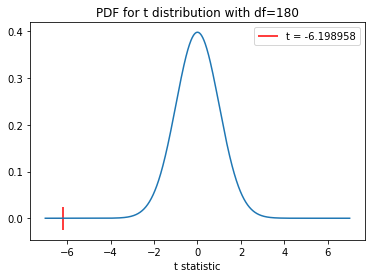

2.4963214721085264e-09


In [13]:
import matplotlib.pyplot as plt
import scipy.stats as st

results = st.ttest_ind(winterC["counts"], summerC["counts"], equal_var=False, alternative='less')

t_dist = st.t(180)
t_x = np.linspace(-7,7,1000)
pdf_vals = t_dist.pdf(t_x)
plt.vlines(tstat, -0.025, 0.025, color = 'r', label='t = -6.198958')
plt.fill_between(t_x, pdf_vals,0, where= t_x<=tstat, color='r')
plt.plot(t_x, pdf_vals)
#plt.plot(tstat, results.pvalue, marker="x", markersize=20)
plt.xlabel('t statistic')
plt.title('PDF for t distribution with df=180')
plt.legend()
plt.show()

print(results.pvalue)


Maybe unsurprisingly, we found that our null hypothesis was immensely wrong. We had allowed ourselves a significance of $0.05$ to reject our result and we found $p\approx2.5e$-$9$. We can say with confidence that Seattle complainers will, in general, be more likely to report their complaints with vegetation in the summer than in the winter.